In [2]:
!mkdir -p ~/.kaggle
!cp Kaggle-5.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muthuj7/weather-dataset

cp: cannot stat 'Kaggle-5.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/muthuj7/weather-dataset
License(s): CC0-1.0
  0% 0.00/2.23M [00:00<?, ?B/s]
100% 2.23M/2.23M [00:00<00:00, 29.6MB/s]


In [3]:
!unzip weather-dataset.zip

Archive:  weather-dataset.zip
  inflating: weatherHistory.csv      


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix

In [7]:
df = pd.read_csv('weatherHistory.csv', parse_dates=['Formatted Date'], index_col='Formatted Date')
df_numeric = df.select_dtypes(include=[np.number])

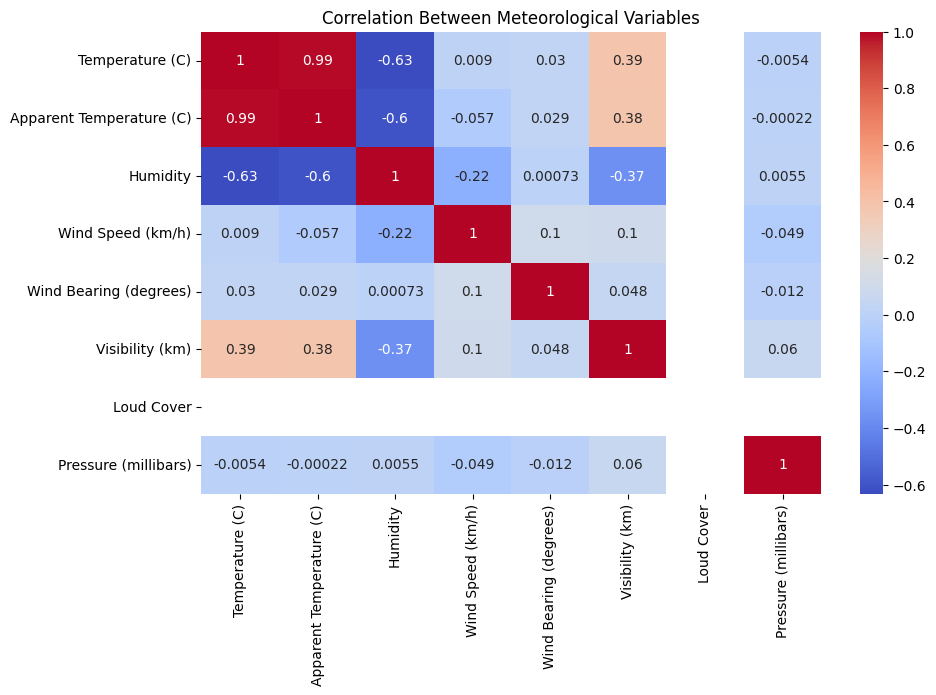

In [8]:
plt.figure(figsize=(10, 6))
sns.heatmap(df_numeric.corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Between Meteorological Variables')
plt.show()

In [9]:
df.fillna(method='ffill', inplace=True)
df['Heatwave'] = (df['Temperature (C)'] > 30).astype(int)
features = df.drop(columns=['Heatwave', 'Summary', 'Precip Type', 'Daily Summary'])
target = df['Heatwave']


<ipython-input-9-00da0e6ada24>:1: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)


In [10]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = scaler.fit_transform(features)


train_size = int(len(df) * 0.8)
X_train, X_test = scaled_features[:train_size], scaled_features[train_size:]
y_train, y_test = target[:train_size], target[train_size:]

In [11]:
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:i + time_steps])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 30
X_train, y_train = create_sequences(X_train, y_train, time_steps)
X_test, y_test = create_sequences(X_test, y_test, time_steps)

<ipython-input-11-90edd39fffef>:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  ys.append(y[i + time_steps])


In [16]:
def build_model(learning_rate=0.001, dropout_rate=0.3):
    model = Sequential()
    model.add(Bidirectional(LSTM(units=64, return_sequences=True), input_shape=(X_train_small.shape[1], X_train_small.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(Bidirectional(LSTM(units=32)))
    model.add(Dropout(dropout_rate))
    model.add(Dense(units=16, activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model


In [17]:
param_grid = {
    'learning_rate': [0.001, 0.005],
    'dropout_rate': [0.3, 0.5]}


In [18]:
best_model = None
best_accuracy = 0


X_train_small = X_train[:10000]
y_train_small = y_train[:10000]

for lr in param_grid['learning_rate']:
    for dr in param_grid['dropout_rate']:
        model = build_model(learning_rate=lr, dropout_rate=dr)
        early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
        reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.0001)


        history = model.fit(X_train_small, y_train_small, validation_split=0.2, epochs=10, batch_size=32,
                            callbacks=[early_stopping, reduce_lr], verbose=0)

        _, accuracy = model.evaluate(X_test, y_test, verbose=0)
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = model

In [19]:
y_pred = (best_model.predict(X_test) > 0.5).astype("int32")

print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

602/602 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step
[[18718    26]
 [  352   165]]
              precision    recall  f1-score   support

           0       0.98      1.00      0.99     18744
           1       0.86      0.32      0.47       517

    accuracy                           0.98     19261
   macro avg       0.92      0.66      0.73     19261
weighted avg       0.98      0.98      0.98     19261



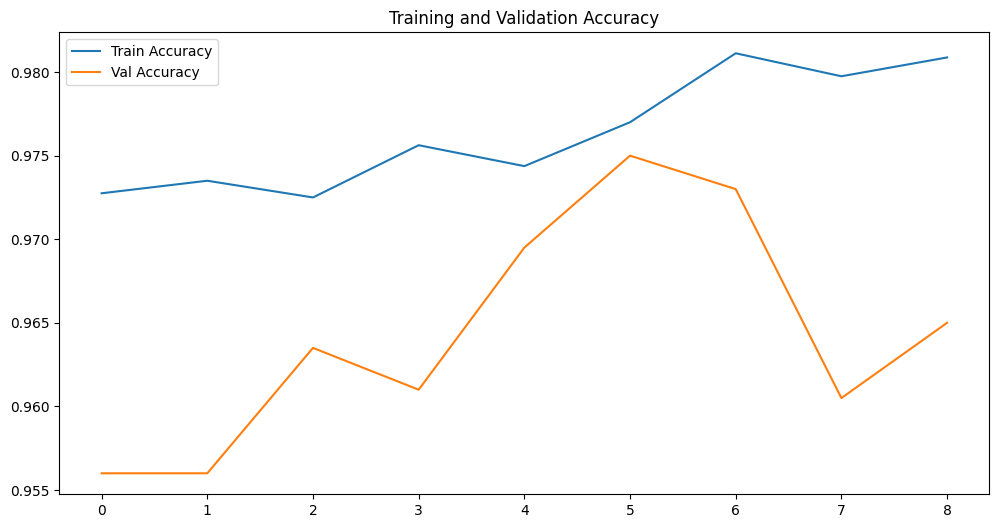

In [20]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

In [22]:
future_climate_data = np.random.rand(30, X_train.shape[2])
scaled_future_data = scaler.transform(future_climate_data)
scaled_future_data = scaled_future_data.reshape(1, 30, X_train.shape[2])

predicted_event = best_model.predict(scaled_future_data)
print(f"Predicted heatwave event probability: {predicted_event}")

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
Predicted heatwave event probability: [[0.08035268]]
